In [1]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import re
import pickle,string
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import pyLDAvis
import pyLDAvis.gensim
import pyLDAvis.sklearn
import gensim

import matplotlib.pyplot as plt
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

/Users/yoyo/opt/anaconda3/lib/python3.8/site-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


In [52]:
df=pd.read_csv('Clean_Hotel_Reviews_tfidf_remove_sampled.csv')
#df.to_excel("Clean_Hotel_Reviews_tfidf_remove_sampled.xlsx",sheet_name='Sheet_name_1') 

<AxesSubplot:>

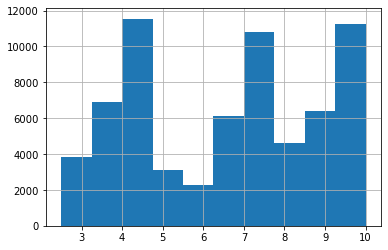

In [53]:
df['Reviewer_Score'].hist()

In [54]:
def clean_text(text):
    if ((text=='No Positive')| ( text=='No Negative')):
        return np.nan
    else:
        text=str(text).lower()
        tokens=nltk.word_tokenize(text)
        tokens_clean=[tok for tok in tokens if tok not in stopwords.words('english') and tok.isdigit()==False and tok not in string.punctuation]
        clean_text=' '.join(tokens_clean)
        clean_text=re.sub('\d+','',clean_text)
        return clean_text
    
def build_model(bag_of_words):
    lda_model = LatentDirichletAllocation(n_components=6, # Number of topics
                                      learning_method='online',
                                      random_state=0,       
                                      n_jobs = -1  # Use all available CPUs
                                     )
    lda_output = lda_model.fit_transform(bag_of_words)
    return lda_model,lda_output


In [56]:
df['Negative_Review_clean']=df['Negative_Review'].apply(clean_text)
review_neg_df=df[['Negative_Review_clean']].reset_index().dropna()
cnt_vect_neg=CountVectorizer(stop_words='english').fit(review_neg_df['Negative_Review_clean'])
bag_of_words_neg = cnt_vect_neg.transform(review_neg_df['Negative_Review_clean'])
id2token_neg={i:v for i,v in enumerate(cnt_vect_neg.get_feature_names())}
lda_model_neg,lda_output_neg = build_model(bag_of_words_neg)

In [64]:
def show_topics(lda_model,id2token):
    for topic_idx,topic in enumerate(lda_model.components_):
        top_n=np.argsort(topic)[-10:]
        top_n_word=[id2token[i] for i in top_n]
        print('Topic '+str(topic_idx+1)+':'+', '.join(top_n_word))

show_topics(lda_model_neg,id2token_neg)

Topic 1:food, bar, paid, good, expensive, star, money, price, hotel, breakfast
Topic 2:tiny, cold, location, hot, air, water, poor, shower, service, room
Topic 3:booked, rude, asked, work, told, booking, check, reception, staff, room
Topic 4:need, better, really, door, stay, like, old, night, bed, hotel
Topic 5:tv, card, experience, stayed, wifi, time, dirty, day, bad, staff
Topic 6:clean, window, noise, double, floor, bathroom, nan, rooms, small, room


In [65]:
topic_theme_neg=['food/bar/paid/expensive(price)','tiny/cold/location/hot(facility)','booked/rude/asked/booking(booking service)',
             'need/door/stay/old(room)','tv/card/wifi/time(facility)','clean/window/noise/floor(room comfort)']
topic_dict_neg=dict(enumerate(topic_theme_neg))


In [66]:
def assign_rev_topic(lda_output,topic_dict,review_pos_df):
    lda_df=pd.DataFrame(np.argmax(lda_output,axis=1),columns=['Topic'])
    lda_df['Theme']=lda_df['Topic'].apply(lambda x: topic_dict[x])
    df_hotel_topic=df[['Hotel_Name','Reviewer_Score']].merge(pd.concat([review_pos_df.reset_index(drop=True),lda_df.reset_index(drop=True)],axis=1),left_index=True,right_on='index')
    return df_hotel_topic
df_hotel_topic_neg=assign_rev_topic(lda_output_neg,topic_dict_neg,review_neg_df)

In [69]:
#save avg score of all negative reviews
df_hotel_topic_neg.groupby('Theme').mean()['Reviewer_Score'].reset_index().to_excel('neg_Theme_avgscore.xlsx')
#(df_hotel_topic_neg.groupby('Theme').count()['Hotel_Name']/df_hotel_topic_neg.shape[0]).reset_index().to_excel('neg_Theme_pct.xlsx')

In [70]:
df_hotel_topic_neg.to_excel('df_hotel_topic_neg.xlsx') 

In [72]:
new_df=pd.read_excel('df_hotel_topic_neg.xlsx',index_col=1)

In [198]:
g=new_df.groupby('Hotel_Name')
rev_by_hotel_neg=g['Negative_Review_clean'].agg(lambda x : ' '.join([i for i in x if type(i)!=float]))
tfidf_vec_hotel_neg=TfidfVectorizer(stop_words='english') 
tfidf_by_hotel_neg=tfidf_vec_hotel_neg.fit_transform(rev_by_hotel_neg)

In [199]:
kw_by_hotel_neg = pd.DataFrame(tfidf_by_hotel_neg.toarray()).apply(lambda x: np.array(list(tfidf_vec_hotel_neg.vocabulary_.keys()))[np.argsort(x)[-10:][::-1]],axis=1)

In [200]:
all_hotels_kw=pd.DataFrame()
for i,hotel_info in enumerate(g):
    hotel=hotel_info[0]
    all_hotels_kw=pd.concat([all_hotels_kw,pd.DataFrame([[hotel,', '.join(kw_by_hotel_neg[i])]])],axis=0)
all_hotels_kw.columns=['hotel','keywords']    
all_hotels_kw.to_excel('hotels_kw.xlsx')    

In [201]:
all_hotels_kw.head()

,hotel,keywords
0,11 Cadogan Gardens,"billes, doshaih, blackmailed, deliver, tricky,..."
0,1K Hotel,"cockrouches, evened, officer, citizen, doshaih..."
0,25hours Hotel beim MuseumsQuartier,"doshaih, citizen, caravans, liquor, british, s..."
0,41,"chilli, citizen, excellence, diy, discretely, ..."
0,45 Park Lane Dorchester Collection,"pentahotel, tomatoes, disposed, irregularity, ..."


In [202]:
topic_doc_sortid=pd.DataFrame(lda_output_neg).apply(lambda x:np.argsort(x)[::-1],axis=0)
topic_doc_sortid=topic_doc_sortid.reset_index(drop=True)
all_topic_rev=pd.DataFrame()
for i,sort_id in topic_doc_sortid.T.iterrows():
    reviews=pd.DataFrame(df['Negative_Review']).iloc[sort_id[:10],:]
    reviews['topic']=topic_theme_neg[i]
    all_topic_rev=all_topic_rev.append(reviews)
all_topic_rev=pd.DataFrame(all_topic_rev).set_index('topic')
all_topic_rev.to_excel('negative_topic_topreviews.xlsx')
all_topic_rev.head()

,Negative_Review
topic,
food/bar/paid/expensive(price),Their room prices were a bit steep Even that ...
food/bar/paid/expensive(price),Breakfast should be included in the price wit...
food/bar/paid/expensive(price),Mildly disappointed in the breakfast Pancakes...
food/bar/paid/expensive(price),I didnt like that we had to pay 50 pounds in ...
food/bar/paid/expensive(price),Expensive breakfast didn t feel like 5 hotel ...
